In [3]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from src.features.statistics import *

## Read Data

- Each row represents one ECG and the columns are the time instances.
- Number of Samples (including normal and abnormal): 14552
- Number of Categories: 2
- Sampling Frequency: 125Hz
- All the samples were downsampled so the had 188 points - some were padded to reach this lenght

In [4]:
data_path = '../data/raw/'
df_normal = pd.read_csv(data_path + 'ptbdb_normal.csv', header=None)
df_anomaly = pd.read_csv(data_path + 'ptbdb_abnormal.csv', header=None)

In [5]:
df_normal.describe().T

,count,mean,std,min,25%,50%,75%,max
0,4046.0,0.979670,0.029061,0.782178,0.964468,1.000000,1.000000,1.000000
1,4046.0,0.711486,0.186376,0.121784,0.580160,0.726449,0.863699,1.000000
2,4046.0,0.311677,0.183457,0.000000,0.164112,0.303266,0.436091,0.985955
3,4046.0,0.119575,0.110457,0.000000,0.028731,0.092655,0.187527,0.910798
4,4046.0,0.088608,0.075760,0.000000,0.027735,0.079476,0.134861,0.846591
...,...,...,...,...,...,...,...,...
183,4046.0,0.000894,0.015311,0.000000,0.000000,0.000000,0.000000,0.483471
184,4046.0,0.000454,0.010834,0.000000,0.000000,0.000000,0.000000,0.371502
185,4046.0,0.000474,0.011202,0.000000,0.000000,0.000000,0.000000,0.376668
186,4046.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [6]:
df_normal.rename(columns={df_normal.columns[-1]: 'label'}, inplace=True)
df_anomaly.rename(columns={df_anomaly.columns[-1]: 'label'}, inplace=True)

## Visualize the data distribution

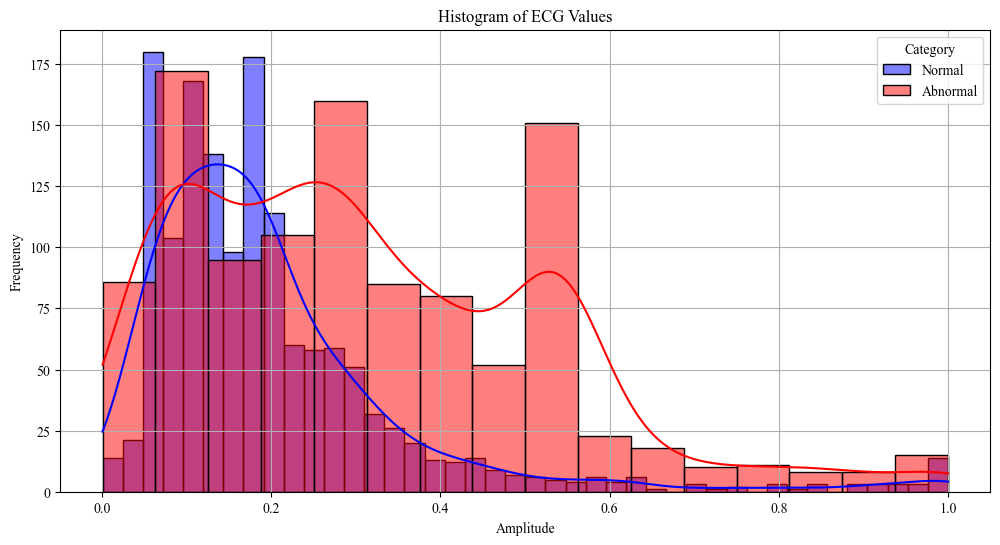

In [7]:
# Plot histograms
plt.rcParams['font.family'] = 'Times New Roman'

sample_normal = df_normal.iloc[:, :-1].sample(10).values.flatten()
sample_normal = [s for s in sample_normal if s > 0]

sample_anomaly = df_anomaly.iloc[:, :-1].sample(10).values.flatten()
sample_anomaly = [s for s in sample_anomaly if s > 0]

plt.figure(figsize=(12, 6))
sns.histplot(sample_normal, kde=True, color='blue', label='Normal')
sns.histplot(sample_anomaly, kde=True, color='red', label='Abnormal')
plt.title('Histogram of ECG Values')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.legend(title='Category')
plt.grid(True)
plt.show()

Seems like the normal and  abnormal signals overlap at smaller values, but the distribution at higher values is much bigger for the anbnormal signals

In [8]:
fig = go.Figure()

# Add trace for normal signal
fig.add_trace(go.Scatter(
    y=sample_normal,
    mode='lines',
    name='Normal'
))

# Add trace for abnormal signal
fig.add_trace(go.Scatter(
    y=sample_anomaly,
    mode='lines',
    name='Abnormal'
))

# Update the layout of the plot
fig.update_layout(
    title='ECG Signal Comparison',
    xaxis_title='Time',
    yaxis_title='Amplitude',
    legend_title='Signal Type',
    margin=dict(l=20, r=20, t=60, b=20),
    width=1000,
    height=400
)

# Show the plot
fig.show()


As the signal have different samples but they have been cut to 118 points, lets try to sumarize it into statistical metricas (such as mean, standard deviation, kurtosis...). But to do it we need to garanty that the signal is stationary, that means statistical properties do not change over time.

To verify stationarity, we use the Augmented Dickey-Fuller (ADF) test. The ADF test is a statistical test that checks for the presence of a unit root in a time series sample. A unit root indicates non-stationarity. If the p-value from the ADF test is less than a threshold (commonly 0.05), we reject the null hypothesis of the test, which means the series is stationary. The following code performs the ADF test on N different random samples from the dataset.

Ps:. stationarity does not mean that the data points themselves do not change; rather, it means the overall distribution and behavior remain consistent.

In [9]:
df_normal.drop(columns='label', inplace=True)
df_anomaly.drop(columns='label', inplace=True)

In [10]:
def apply_adf(series):
    # Remove zero values added for padding from the series
    series = series[series != 0]
    
    adf_test = adf.adfuller(series)
    result = {
        'ADF Statistic': adf_test[0],
        'p-value': adf_test[1],
        'Critical Values': adf_test[4],
        'Is Stationary': adf_test[1] < 0.05  # Typically, a p-value < 0.05 indicates stationarity
    }
    return result

def test_adf_df(df, n=5):
    # Select n random rows/samples in datasetclasse
    random_samples = df.sample(n=n, random_state=40)
    results_adf = random_samples.apply(apply_adf, axis=1)
    return results_adf

adf_normal = test_adf_df(df_normal.iloc[:,:-2])
adf_anomaly = test_adf_df(df_anomaly.iloc[:,:-2])

In [11]:
print("ADF Test for normal signals:")
for i, result in enumerate(adf_normal, start=1):
    print(f"Sample {i}:")
    print(f"ADF Statistic: {result['ADF Statistic']}")
    print(f"p-value: {result['p-value']}")
    print(f"Is Stationary: {'Yes' if result['Is Stationary'] else 'No'}")    
    print("\n")

ADF Test for normal signals:
Sample 1:
ADF Statistic: -4.118899324821967
p-value: 0.0009011551926511467
Is Stationary: Yes


Sample 2:
ADF Statistic: -4.453966428741318
p-value: 0.0002379356595351235
Is Stationary: Yes


Sample 3:
ADF Statistic: -3.9565349646836885
p-value: 0.0016560119923837604
Is Stationary: Yes


Sample 4:
ADF Statistic: -4.978984799743654
p-value: 2.4419630645083916e-05
Is Stationary: Yes


Sample 5:
ADF Statistic: -4.9515281737794155
p-value: 2.7654780165271822e-05
Is Stationary: Yes




In [12]:
print("ADF Test for abnormal signals:")
for i, result in enumerate(adf_anomaly, start=1):
    print(f"Sample {i}:")
    print(f"ADF Statistic: {result['ADF Statistic']}")
    print(f"p-value: {result['p-value']}")
    print(f"Is Stationary: {'Yes' if result['Is Stationary'] else 'No'}")    
    print("\n")

ADF Test for abnormal signals:
Sample 1:
ADF Statistic: -3.4626427567236013
p-value: 0.008999967728314292
Is Stationary: Yes


Sample 2:
ADF Statistic: -3.0253101296512983
p-value: 0.032597408443721713
Is Stationary: Yes


Sample 3:
ADF Statistic: -3.7061150744835825
p-value: 0.004027957721198037
Is Stationary: Yes


Sample 4:
ADF Statistic: -2.590746303246428
p-value: 0.09492494087699654
Is Stationary: No


Sample 5:
ADF Statistic: -5.0320676690236485
p-value: 1.9168543560541077e-05
Is Stationary: Yes




For one of the abnormal samples, the signal is not stationary. Let's visualize the mean and standard deviation, but we need to be careful about using it

In [13]:
df_normal['Mean'], df_normal['Std'], df_normal['Kurtosis'], df_normal['Skewness'] = zip(*df_normal.apply(calculate_stats, axis=1))


df_anomaly['Mean'], df_anomaly['Std'], df_anomaly['Kurtosis'], df_anomaly['Skewness'] = zip(*df_anomaly.apply(calculate_stats, axis=1))


In [14]:
fig = go.Figure()
# Add trace for normal signal

# Add trace for abnormal signal
fig.add_trace(go.Scatter(
    y=df_anomaly['Mean'][:1000],
    mode='lines',
    name='Abnormal - Mean'
))


fig.add_trace(go.Scatter(
    y=df_normal['Mean'][:1000],
    mode='lines',
    name='Normal - Mean'
))

fig.add_trace(go.Scatter(
    y=df_anomaly['Std'][:1000],
    mode='lines',
    name='Abnormal - Std'
))


fig.add_trace(go.Scatter(
    y=df_normal['Std'][:1000],
    mode='lines',
    name='Normal - Std'
))

# Update the layout of the plot
fig.update_layout(
    title='ECG Signal Comparison',
    xaxis_title='Time',
    yaxis_title='Amplitude',
    legend_title='Signal Type',
    margin=dict(l=20, r=20, t=60, b=20),
    width=1000,
    height=400
)

# Show the plot
fig.show()

In [15]:
import plotly.graph_objects as go

fig = go.Figure()

# Add trace for skewness (asymmetry) in the abnormal signal
fig.add_trace(go.Scatter(
    y=df_anomaly['Skewness'][:1000],
    mode='lines',
    name='Abnormal - Skewness'
))

# Add trace for skewness in the normal signal
fig.add_trace(go.Scatter(
    y=df_normal['Skewness'][:1000],
    mode='lines',
    name='Normal - Skewness'
))

# Add trace for kurtosis in the abnormal signal
fig.add_trace(go.Scatter(
    y=df_anomaly['Kurtosis'][:1000],
    mode='lines',
    name='Abnormal - Kurtosis'
))

# Add trace for kurtosis in the normal signal
fig.add_trace(go.Scatter(
    y=df_normal['Kurtosis'][:1000],
    mode='lines',
    name='Normal - Kurtosis'
))

# Update the layout of the plot
fig.update_layout(
    title='Comparison of Skewness and Kurtosis',
    xaxis_title='Index',
    yaxis_title='Value',
    legend_title='Metric Type',
    margin=dict(l=20, r=20, t=60, b=20),
    width=1000,
    height=400
)

# Show the plot
fig.show()

- Observing the mean signal and its standard deviation, it is evident that abnormal ECG signals have a significantly higher amplitude compared to normal signals. This indicates that the fluctuations in the signal are more pronounced in abnormal conditions. Additionally, the standard deviation, which measures the amount of variation or dispersion of the signal, is also greater in abnormal ECG signals. 
- Furthermore, the higher skewness in abnormal signals suggests an asymmetry in amplitude distribution, often associated with arrhythmias or other cardiac anomalies that affect heartbeat regularity and waveform symmetry. The elevated kurtosis indicates the presence of more extreme outliers or sharp spikes, characteristic of severe cardiac conditions like ventricular tachycardia. These statistical metrics collectively provide a detailed perspective on the distinct behavior of normal versus abnormal ECG signals. 
- This increased variability suggests that abnormal signals are less consistent and more erratic, further highlighting the difference in behavior between normal and abnormal ECG signals.

## Time series decomposition

Time series decomposition involves breaking down a time series into several components to better understand its structure and behavior.

The main components are:

- Trend: The long-term progression or direction in the data.
- Seasonality: The repeating short-term cycle in the series.
- Residual: The remaining part after removing the trend and seasonality, which represents random noise or irregular patterns.

Interpreting Decomposition for Heart Beat

- Trend: Helps identify whether the heart's electrical activity is increasing or decreasing over time.
- Seasonality: May reveal periodic cycles, like regular heartbeats.
- Residual: Indicates anomalies or noise after removing trend and seasonality.

In [17]:
# Decompose the time series
decomposition_normal = seasonal_decompose(df_normal['Mean'], period=60, model='additive')
decomposition_abnormal = seasonal_decompose(df_anomaly['Mean'], period=60, model='additive')

# Create subplots
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, subplot_titles=['Observed', 'Trend', 'Seasonal', 'Residual'])

# Observed
fig.add_trace(go.Scatter(y=decomposition_normal.observed, mode='lines', name='Normal - Observed', line=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(y=decomposition_abnormal.observed, mode='lines', name='Abnormal - Observed', line=dict(color='red')), row=1, col=1)

# Trend
fig.add_trace(go.Scatter(y=decomposition_normal.trend, mode='lines', name='Normal - Trend', line=dict(color='blue')), row=2, col=1)
fig.add_trace(go.Scatter(y=decomposition_abnormal.trend, mode='lines', name='Abnormal - Trend', line=dict(color='red')), row=2, col=1)

# Seasonal
fig.add_trace(go.Scatter(y=decomposition_normal.seasonal, mode='lines', name='Normal - Seasonal', line=dict(color='blue')), row=3, col=1)
fig.add_trace(go.Scatter(y=decomposition_abnormal.seasonal, mode='lines', name='Abnormal - Seasonal', line=dict(color='red')), row=3, col=1)

# Residual
fig.add_trace(go.Scatter(y=decomposition_normal.resid, mode='lines', name='Normal - Residual', line=dict(color='blue')), row=4, col=1)
fig.add_trace(go.Scatter(y=decomposition_abnormal.resid, mode='lines', name='Abnormal - Residual', line=dict(color='red')), row=4, col=1)

# Update layout
fig.update_layout(height=800, width=1000, title_text='Time Series Decomposition', showlegend=True)
fig.update_xaxes(title_text='Time', row=4, col=1)
fig.update_yaxes(title_text='Value')

# Show the plot
fig.show()


## Main conclusions:

- Seasonal Patterns: Both the normal and abnormal signals display recurring patterns, indicating seasonality. The signal apear to have consistent peaks and troughs at regular intervals. That's a typical characteristic of biological signals and may reveals the regular heartbeats.
- Trend components: Visualy, for the normal ECG, the trend remains relatively flat with minor fluctuations, indicating a stable baseline heart activity. While abnormaal ECG shows more pronounced fluctuations and higher values, indicating variability and potentially unstable heart activity over time.
- Hypothesis: A stable trend in normal ECG data implies consistent heart function, while the fluctuating trend in abnormal ECG data may suggest underlying cardiac issues that need further investigation.

## Autocorrelation Function 

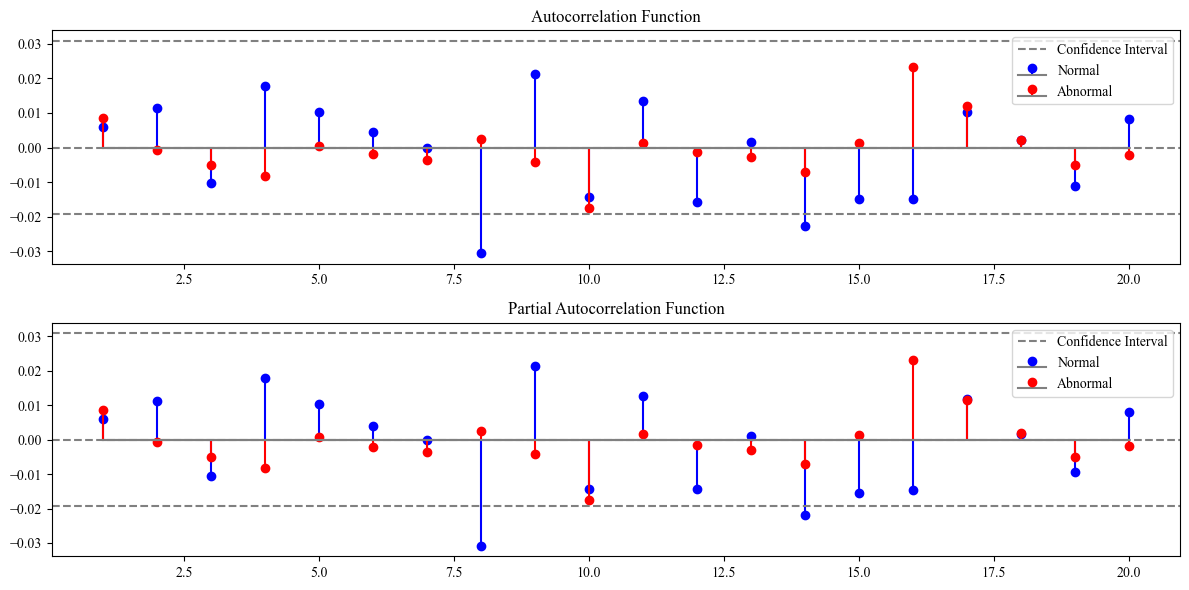

In [18]:
lag_acf_normal= acf(df_normal['Mean'], nlags=20)[1:]  # Exclude lag-0
lag_pacf_normal = pacf(df_normal['Mean'], nlags=20, method='ols')[1:]  # Exclude lag-0

lag_acf_abnormal= acf(df_anomaly['Mean'], nlags=20)[1:]  # Exclude lag-0
lag_pacf_abnormal = pacf(df_anomaly['Mean'], nlags=20, method='ols')[1:]  # Exclude lag-0

lags = range(1, 21)  # Adjust lags to start from 1

# Plot ACF for normal and abnormal data
plt.figure(figsize=(12, 6))

# Plot ACF for normal and abnormal data
plt.subplot(211)
plt.stem(lags, lag_acf_normal, linefmt='b-', markerfmt='bo', basefmt='gray', label='Normal')
plt.stem(lags, lag_acf_abnormal, linefmt='r-', markerfmt='ro', basefmt='gray', label='Abnormal')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_normal)), linestyle='--', color='gray', label='Confidence Interval')
plt.axhline(y=-1.96/np.sqrt(len(df_anomaly)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')
plt.legend()

# Plot PACF for normal and abnormal data
plt.subplot(212)
plt.stem(lags, lag_pacf_normal, linefmt='b-', markerfmt='bo', basefmt='gray', label='Normal')
plt.stem(lags, lag_pacf_abnormal, linefmt='r-', markerfmt='ro', basefmt='gray', label='Abnormal')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_normal)), linestyle='--', color='gray', label='Confidence Interval')
plt.axhline(y=-1.96/np.sqrt(len(df_anomaly)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.legend()

plt.tight_layout()
plt.show()

Both normal and abnormal ECG signals exhibit low autocorrelation beyond lag-1, indicating that these signals have little dependence on past values other than the one immediately preceding them. Interestingly, there is a slight increase in autocorrelation at lags 8 and 16, suggesting a subtle influence from the more immediate past, though the reasons for these specific peaks remain unclear. Overall, the results indicate that both types of ECG signals demonstrate weak dependencies on prior values beyond the most recent. This insight is valuable for constructing time series models and for a deeper understanding of the structural dynamics within ECG signals.

## Umap Visualization

c:\Users\maria\.conda\envs\ecg-env\lib\site-packages\umap\umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



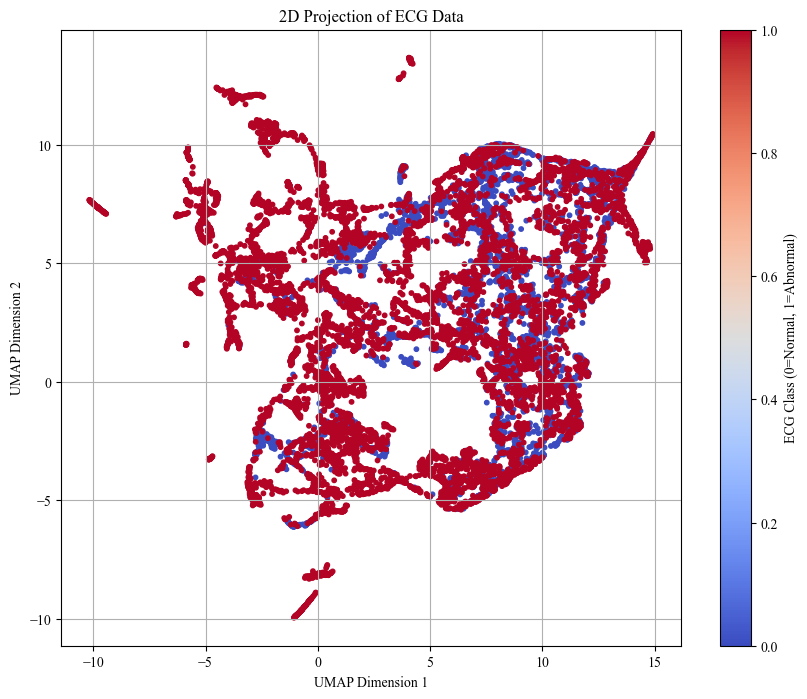

In [21]:
# Combine your data if separated, or use a single DataFrame if already combined
data = pd.concat([df_normal, df_anomaly])
labels = np.array([0]*len(df_normal) + [1]*len(df_anomaly))  # 0 for normal, 1 for abnormal

# Fitting UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(data)

# Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='coolwarm', s=10)
plt.title('2D Projection of ECG Data')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(scatter, label='ECG Class (0=Normal, 1=Abnormal)')
plt.grid(True)
plt.show()

When visualizing the data with UMAP, the signals don't seem to exhibit clear separability. They appear overlapped in some areas and seem to be differentiated primarily by their amplitude rather than distinct clusters.

In [82]:
path = '../data/processed/'

df_normal.columns = df_normal.columns.map(str)
df_anomaly.columns = df_anomaly.columns.map(str)

df_normal.to_parquet(path + 'ptdb_normal.parquet')
df_anomaly.to_parquet(path + 'ptdb_abnormal.parquet')